In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

In [2]:
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [3]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt


    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [5]:
tickerSymbol = 'NVDA'
data = yf.Ticker(tickerSymbol)

In [6]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

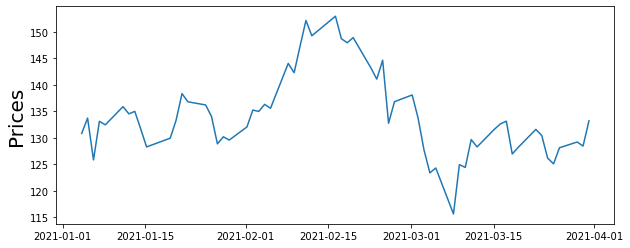

In [7]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Returns')

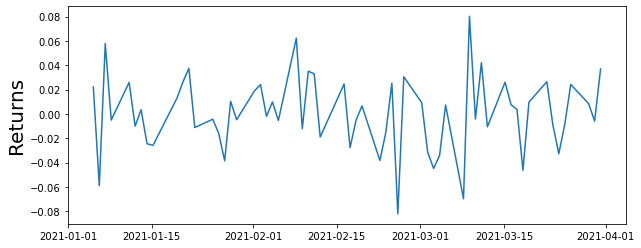

In [8]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Returns',fontsize=20)

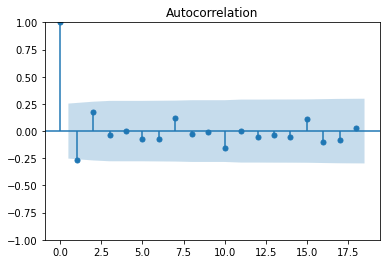

In [9]:
plot_acf(returns)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


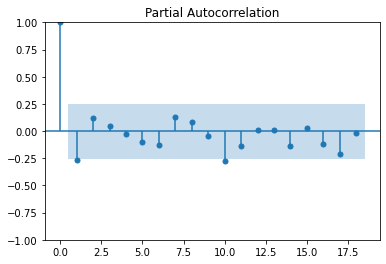

In [13]:
plot_pacf(returns)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 9195.84it/s]


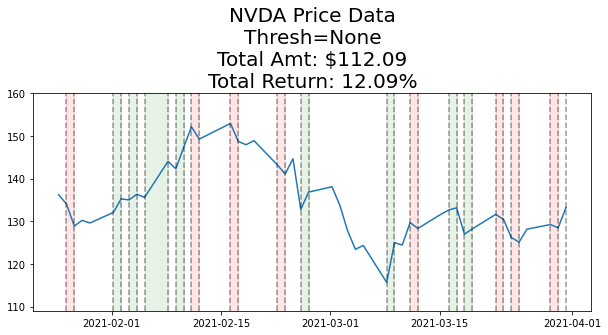

112.08597804669245

In [14]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [15]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11498.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11528.32it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 15361.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 15358.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 15349.08it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11524.88it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11515.25it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11522.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11511.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11530.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11511.13it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11493.30it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11515.25it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11491.24it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11502.89it/s]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $99.5\nSD: $11.58')

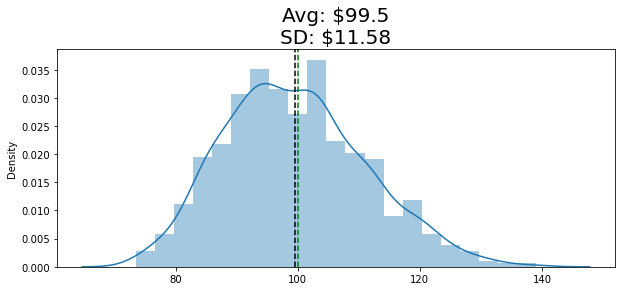

In [16]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 15294.33it/s]


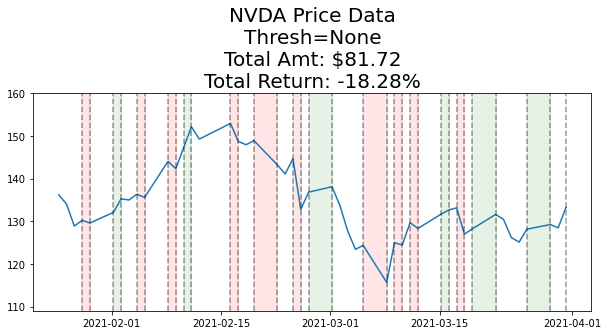

81.71509816811952

In [17]:
run_simulation(returns,prices,100,'last',None,verbose=False)